# Data visualization throttled:
Unthrottled memory power = ~3000

| # | Setting |
| --- | --- |
| Device | macbook pro 14-inch, 2023 | 
| Chip | Apple M2 Pro | 
| Memory | 16 GB | 
| macOS | 15.1.1 | 
| Java | openjdk 21.0.5 | 
| Node | v23.3.0 | 
| Angular | v18.2.x | 

## Throttling

| # | Setting |
| --- | --- |
| CPU | 4x CPU slowdown | 
| download | 1.6 Mbps | 
| upload | 750 Kbps | 
| latency | 150ms | 

## Core Web Vitals Measurements:

**Long task**
- Task that takes more than 50ms

**TTFB (Time to First Byte):**
 - Time from navigation start until the first byte of response is received
 - Calculated using: performance.getEntriesByType('navigation')[0].responseStart
 
**FCP (First Contentful Paint):**
 - Time when the first text, image, or other content appears on the screen.
 - Is the 'endTime' of the first-contentful-paint
 - FCP includes all things that happened before it (like TTFB).
 
**LCP (Largest Contentful Paint):**
 - Time when the largest text or image element is rendered on the screen (so endTime)
 - Is the 'endTime' of the largest-contentful-paint.
 - FCP includes all things that happened before it (like TTFB).
 
**TTI (Time to Interactive):**
 - Time when the page becomes 'reliably' interactive
 - It is measured as the endtime of the last 'long task' after the FCP starttime
 - If no tasks are found, it is the end-time of the FCP.
 
**TBT (Total Blocking Time):**
 - Sum of all "blocking time" for long tasks between start of FCP and TTI
 - Blocking time = accumulation of (task duration - 50ms) of each long task.
 - TBT contains a 'quiet window' of 5s, if this window is expired, the test will end.
 - The quiet window starts after the FCP. 

In [48]:
run8path = '../../../data/core-web-vitals/testrun-8'

In [49]:
import pandas as pd;
import numpy as np;
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests

pd.set_option('display.float_format', lambda x: '%.2f' % x)


dataset_A = pd.read_csv(f'{run8path}/results-csr.csv', sep=',')
dataset_B = pd.read_csv(f'{run8path}/results-csr-throttled.csv', sep=',')

features = ['navTime', 'totalTime', 'lcp', 'fcp', 'ttfb', 'tbt', 'tti', 'longestTask', 'longTasks', 'nf:init', 'nf:config', 'nf:loaded']
target_features = ['ttfb', 'fcp', 'lcp', 'tti', 'tbt', 'nf:init', 'nf:loaded']

# Remove Java warmup
dataset_A = dataset_A.iloc[5:]
dataset_B = dataset_B.iloc[5:]

datasets =	{
  "unthrottled": dataset_A,
  "throttled": dataset_B,
}

dataset_B.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 5 to 504
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   idx          500 non-null    int64  
 1   site         500 non-null    object 
 2   date         500 non-null    object 
 3   time         500 non-null    object 
 4   navTime      500 non-null    int64  
 5   totalTime    500 non-null    int64  
 6   lcp          500 non-null    float64
 7   fcp          500 non-null    float64
 8   ttfb         500 non-null    float64
 9   tbt          500 non-null    int64  
 10  tti          500 non-null    float64
 11  longTasks    500 non-null    int64  
 12  longestTask  500 non-null    int64  
 13  nf:init      500 non-null    float64
 14  nf:config    500 non-null    float64
 15  nf:loaded    500 non-null    float64
 16  error        0 non-null      float64
dtypes: float64(8), int64(6), object(3)
memory usage: 66.5+ KB


             Total Points  Outliers Percentage Removed
unthrottled           500        50              10.0%
throttled             500        50              10.0%


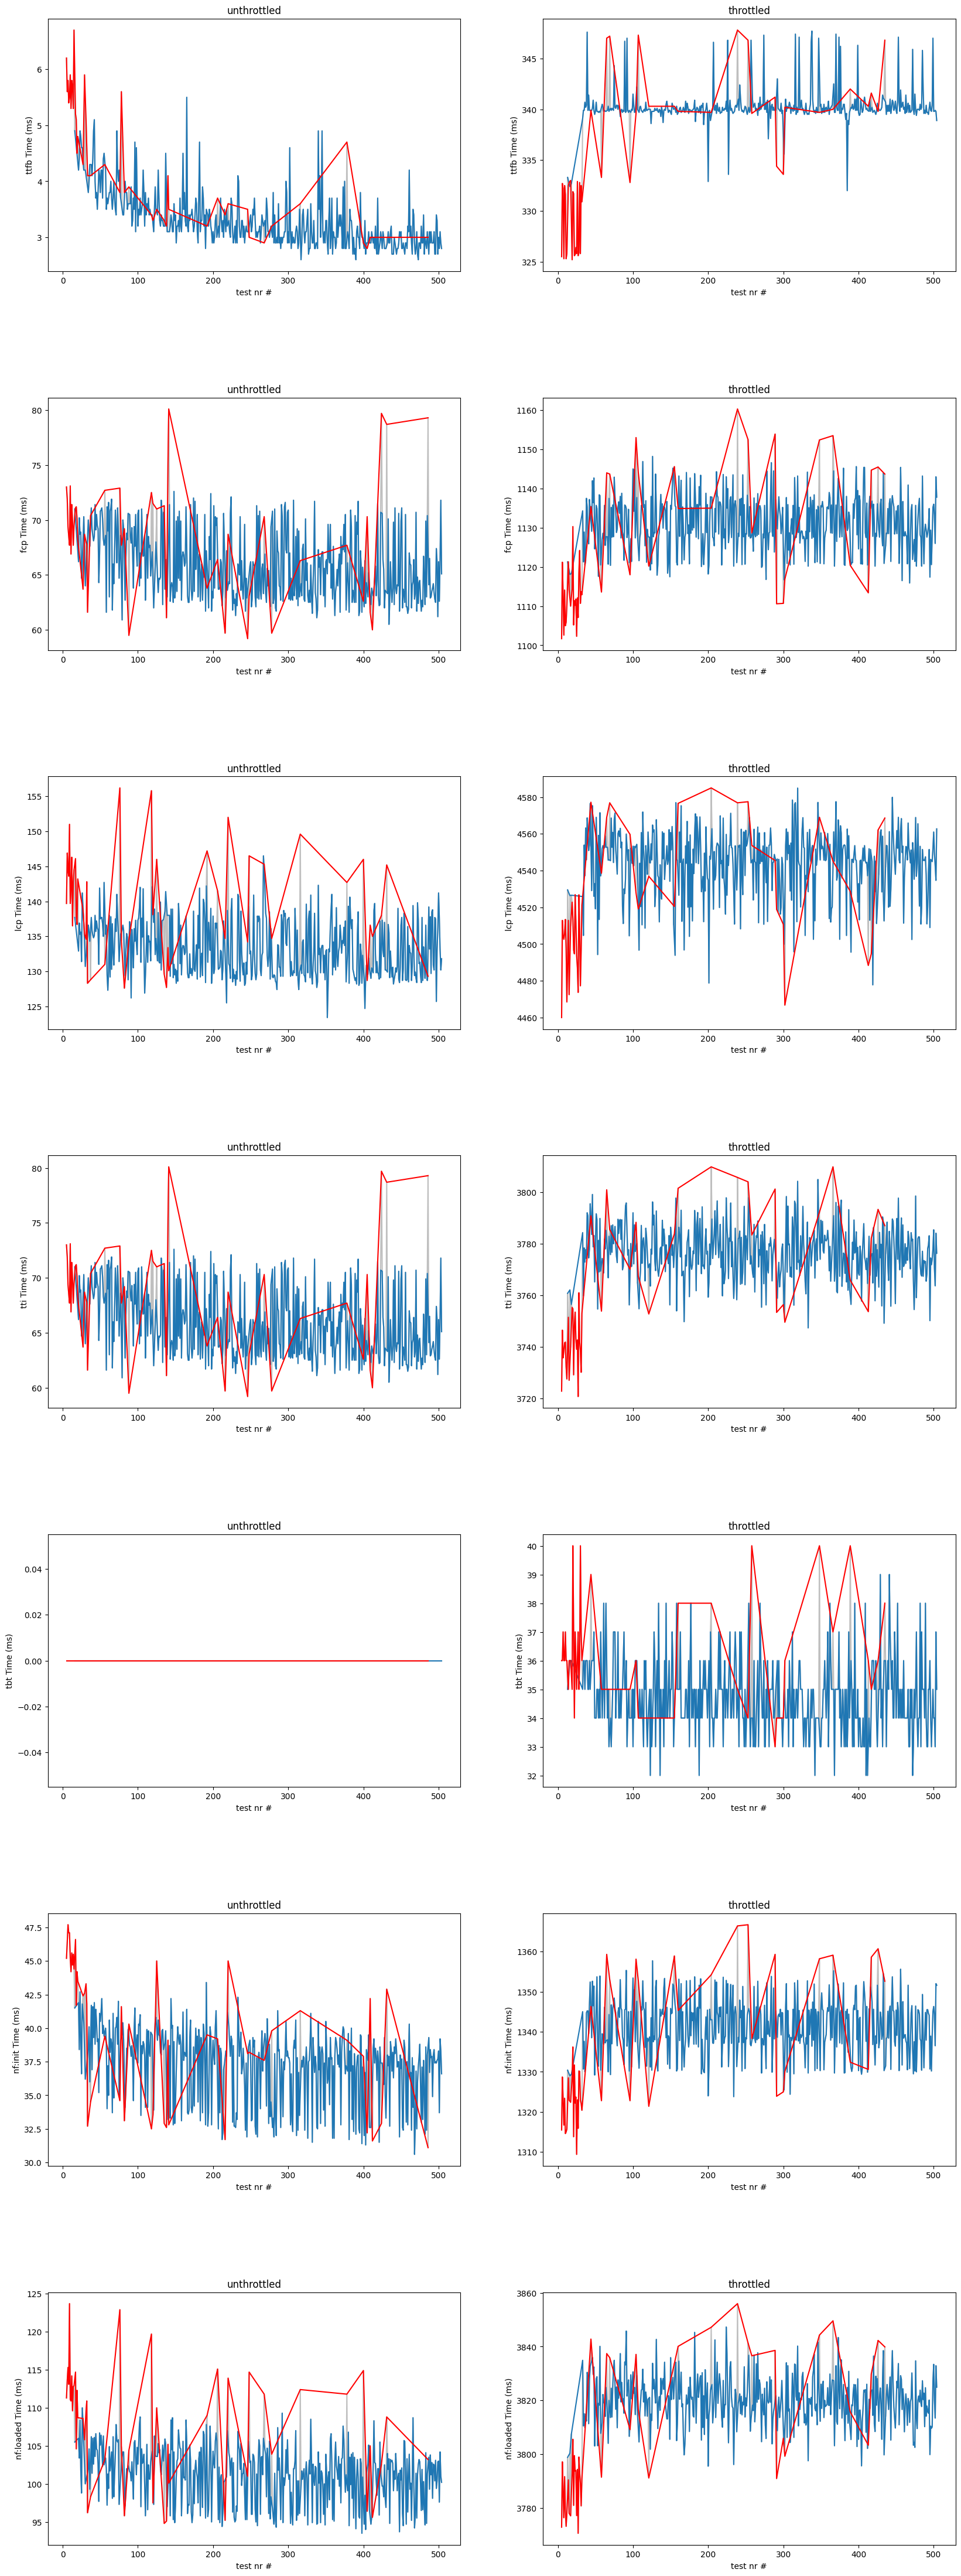

In [42]:
def detect_outliers(df, features, contamination=0.1):
    clf = IsolationForest(contamination=contamination, random_state=42)
    outliers = clf.fit_predict(df[features])
    return outliers == 1

# def plot_outliers(d, f, loc, mask):
#     loc.hist(datasets[d][f][mask[d]], bins=30, alpha=0.7, label='Inliers', edgecolor='k')
#     loc.hist(datasets[d][f][~mask[d]], bins=30, alpha=0.7, label='Outliers', color='red', edgecolor='k')
#     loc.set_title(d)
#     loc.set_ylabel('Frequency')
#     loc.set_xlabel(f'Distribution of {f}')
#     loc.legend()


def plot_outliers(d, f, loc, mask):
    loc.plot(datasets[d][f], label='dirty', color='gray', alpha=0.5)
    loc.plot(datasets[d][f][mask[d]], label=d)
    loc.plot(datasets[d][f][~mask[d]], label='outliers', color='red')

    loc.set_title(d)
    loc.set_ylabel(f'{f} Time (ms)') 
    loc.set_xlabel('test nr #') 

def visualize_outliers(features, masks, height=8):
    rows = len(features)
    cols = len(datasets)
    
    _, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, height*rows))
    plt.subplots_adjust(hspace=0.5)
    
    for y, f in enumerate(features):
        for x, d in enumerate(datasets):
            plot_outliers(d, f, axes[y, x], masks)
    return plt

def print_outlier_stats(datasets, masks):
    stats = {}
    for name, df in datasets.items():
        total = len(df)
        outliers = (~masks[name]).sum()
        pct = (outliers / total) * 100
        stats[name] = {
            'total': total,
            'outliers': outliers,
            'percentage': pct
        }
    
    stats_df = pd.DataFrame({
        'Total Points': [stats[name]['total'] for name in stats],
        'Outliers': [stats[name]['outliers'] for name in stats],
        'Percentage Removed': [f"{stats[name]['percentage']:.1f}%" for name in stats]
    }, index=datasets.keys())
    
    return stats_df

masks = {}
cleaned_datasets = {}

for name, df in datasets.items():
    mask = detect_outliers(df, target_features)
    masks[name] = mask
    cleaned_datasets[name] = df[mask].copy()

print(print_outlier_stats(datasets, masks))

visualize_outliers(target_features, masks)
plt.show()

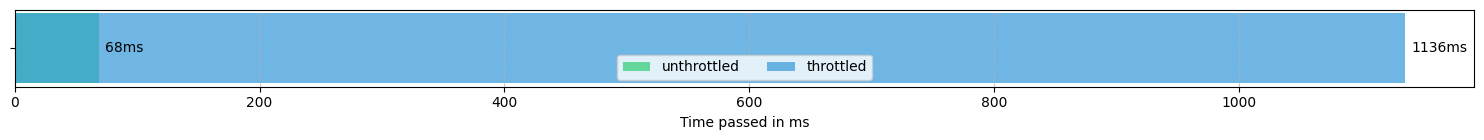

In [51]:
fig, ax = plt.subplots(figsize=(15, 1.5))

dataset_names = list(cleaned_datasets.keys())
fcp_values = [df['fcp'].quantile(0.75) for df in cleaned_datasets.values()]

bar_height = 0.25
y_positions = [0.5, 0.5, 0.5]  # Same y-position for overlap
colors = ['#2ecc71', '#3498db', '#e74c3c']  # Different colors for distinction

bars = []
for i, (name, value) in enumerate(zip(dataset_names, fcp_values)):
    bar = ax.barh(y_positions[i], value, height=bar_height, 
                 label=name, color=colors[i], alpha=0.7)
    bars.append(bar)

ax.set_yticks([0.5])
ax.set_yticklabels([''])
ax.set_xlabel('Time passed in ms')
# ax.set_title('Comparison of First Contentful Paint (CSR)')

ax.grid(True, axis='x', linestyle='--', alpha=0.7)

for i, bar in enumerate(bars):
    width = bar[0].get_width()
    ax.text(width + 5, bar[0].get_y() + bar[0].get_height()/2, 
            f'{fcp_values[i]:.0f}ms', 
            va='center')

ax.legend(loc='lower center', ncols=3)

plt.tight_layout()

plt.show()

<module 'matplotlib.pyplot' from '/Users/auke/Library/Python/3.9/lib/python/site-packages/matplotlib/pyplot.py'>

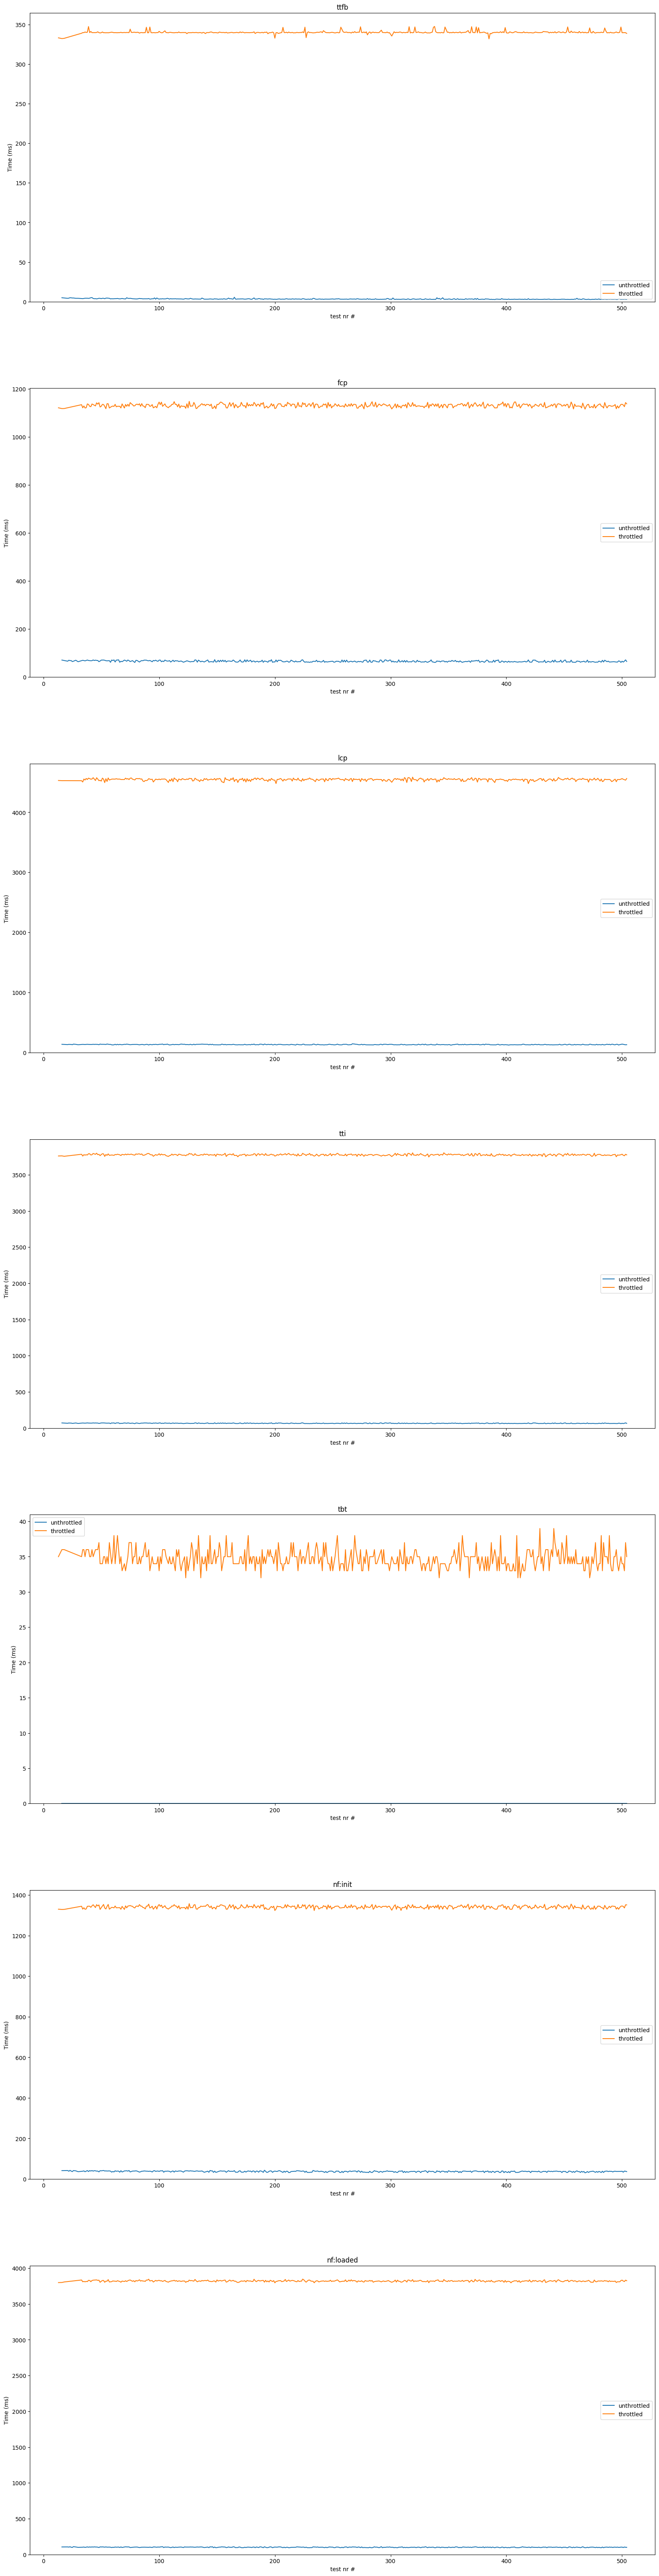

In [52]:
def ceildiv(a, b): return -(a // -b)

def plot_box_plot(f, loc):
    [loc.plot(cleaned_datasets[d][f], label=d) for d in cleaned_datasets]

    loc.set_title(f)
    loc.set_ylabel('Time (ms)') 
    loc.set_xlabel('test nr #') 
    loc.set_ylim(bottom=0)
    loc.legend()

def graphs(plot_func, features, height=10):
    rows = len(features)

    _, axes = plt.subplots(nrows=rows, figsize=(20, height*rows))
    plt.subplots_adjust(hspace=0.3, top=0.95, bottom=0.05)  
    for y, f in enumerate(features):
        plot_func(f, axes[y])
    return plt

graphs(plot_box_plot, target_features)

In [53]:

keys = list(cleaned_datasets.keys())

results = pd.DataFrame([
    [metric, 'two-sided', stats.mannwhitneyu(cleaned_datasets[keys[0]][metric], 
                                   cleaned_datasets[keys[1]][metric], 
                                   alternative='two-sided')[1]]
    for metric in target_features
], columns=['metric', 'hypothesis', 'p_value'])

results['adjusted_p'] = multipletests(results['p_value'], method='bonferroni')[1]
results['significant'] = results['adjusted_p'] < 0.05

compact_format = lambda x: '%.3e' % x if x < 0.00001 else '%.5f' % x
results['p_value'] = results['p_value'].apply(compact_format)
results['adjusted_p'] = results['adjusted_p'].apply(compact_format)

results

,metric,hypothesis,p_value,adjusted_p,significant
0,ttfb,two-sided,8.626e-149,6.038e-148,True
1,fcp,two-sided,1.181e-148,8.270e-148,True
2,lcp,two-sided,1.187e-148,8.308e-148,True
3,tti,two-sided,1.186e-148,8.300e-148,True
4,tbt,two-sided,3.700e-171,2.590e-170,True
5,nf:init,two-sided,1.180e-148,8.263e-148,True
6,nf:loaded,two-sided,1.188e-148,8.315e-148,True


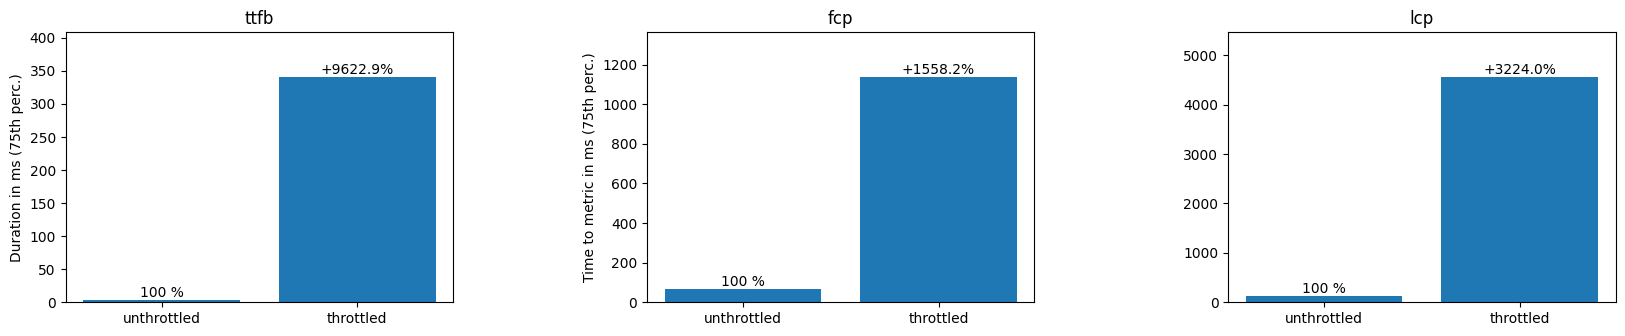

In [54]:
metrics = ['ttfb', 'fcp', 'lcp']

def plot_bar_chart(feature, loc, idx):
    percentiles = {d: cleaned_datasets[d][feature].quantile(0.75) for d in datasets}
    bars = loc.bar(percentiles.keys(), percentiles.values())
    
    baseline = list(percentiles.values())[0]
    max_height = max(percentiles.values())
    
    # Add 20% padding to the top of each chart
    loc.set_ylim(0, max_height * 1.2)
    
    for i, bar in enumerate(bars):
        height = bar.get_height()
        percentage = ((height / baseline) - 1) * 100
        label = f'100 %' if (i == 0) else f'{percentage:+.1f}%'
        loc.text(bar.get_x() + bar.get_width()/2., height,
                label,
                ha='center', va='bottom')
    
    loc.set_title(feature)
    if idx==0:
        loc.set_ylabel('Duration in ms (75th perc.)')
    if idx==1:
        loc.set_ylabel('Time to metric in ms (75th perc.)')

def graphs(plot_func, features, height=3):
    cols = len(features)
    _, axes = plt.subplots(ncols=cols, figsize=(20, height))
    plt.subplots_adjust(hspace=0.3, wspace=0.5, top=0.95, bottom=0.05)
    for y, f in enumerate(features):
        plot_func(f, axes[y], idx=y)
    return plt

graphs(plot_bar_chart, metrics)
plt.show()

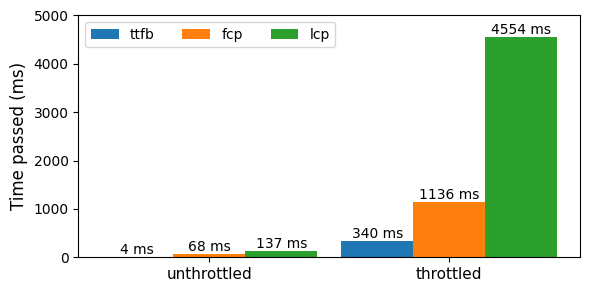

In [55]:
# Create figure with larger size for better readability
plt.figure(figsize=(6, 3))

# Calculate positions
x = np.arange(len(datasets))
bar_width = 0.3  # Reduced width to prevent overlap

# Create bars
max_value = 0
for i, metric in enumerate(metrics):
    position = x + (i - len(metrics)/2 + 0.5) * bar_width
    values = [cleaned_datasets[dataset][metric.lower()].quantile(0.75) for dataset in datasets]
    bars = plt.bar(position, values, bar_width, label=metric)
    max_value = max(max_value, max(values))

    # Add values on top of the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, f'{int(round(yval, 0))} ms', ha='center', va='bottom')

# Customize the plot
plt.ylabel('Time passed (ms)', fontsize=12)

# Set x-axis ticks
plt.xticks(x, datasets, fontsize=11)

# Add legend with better positioning
plt.legend(loc='upper left', fontsize=10, ncol=3)

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.ylim(0, max_value * 1.1)

plt.show()